In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#4476C2",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

# Helper to avoid overlapping x tick labels: wraps long labels, rotates, and
# ensures enough bottom margin. Use `fix_tick_labels(ax)` after drawing plots.
def fix_tick_labels(ax=None, rotation=45, ha='right', wrap_width=20, bottom=0.30):
    import textwrap
    if ax is None:
        ax = plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    if any(labels):
        wrapped = [textwrap.fill(l, wrap_width) if l else l for l in labels]
        ax.set_xticklabels(wrapped, rotation=rotation, ha=ha)
    # Increase bottom margin to make room for multi-line labels
    try:
        fig = ax.get_figure()
        fig.subplots_adjust(bottom=bottom)
    except Exception:
        plt.subplots_adjust(bottom=bottom)
    plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

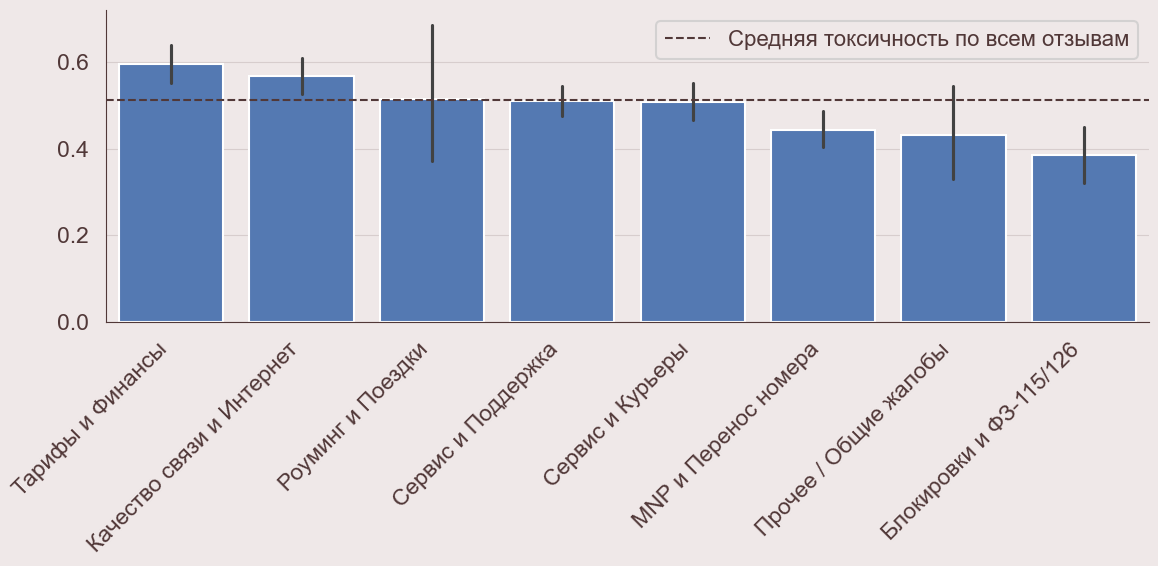

/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_62977/2721965717.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


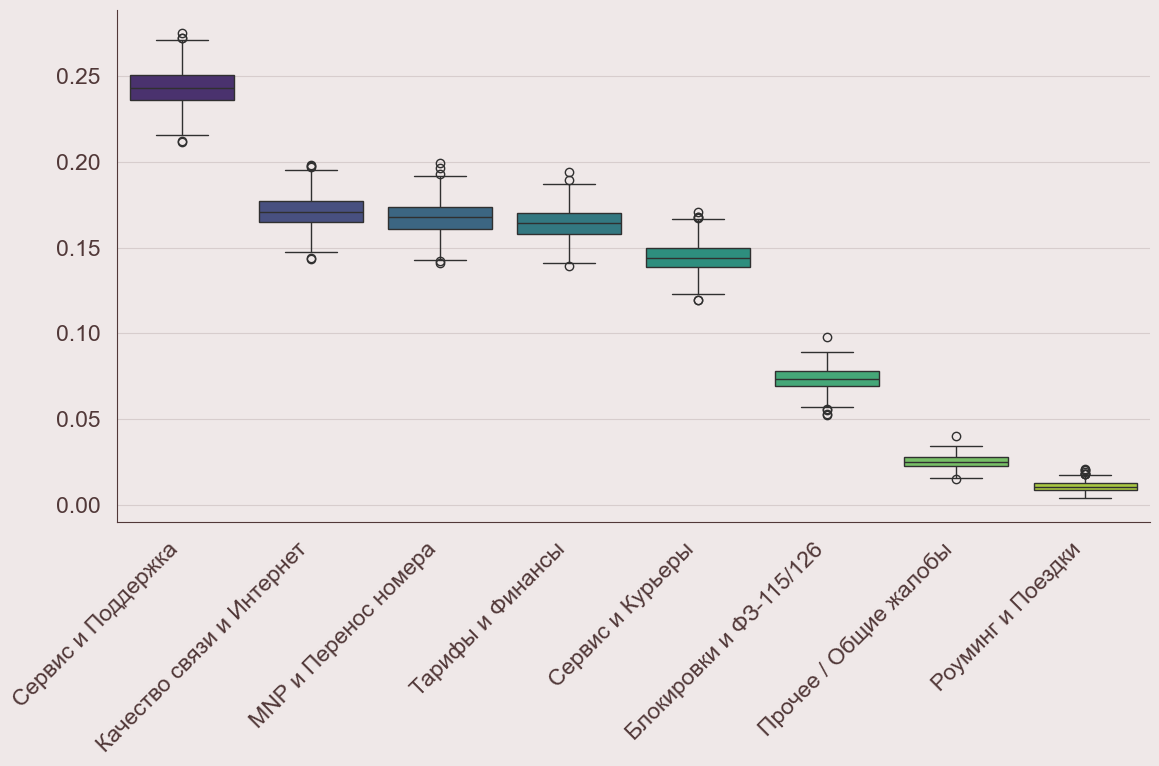

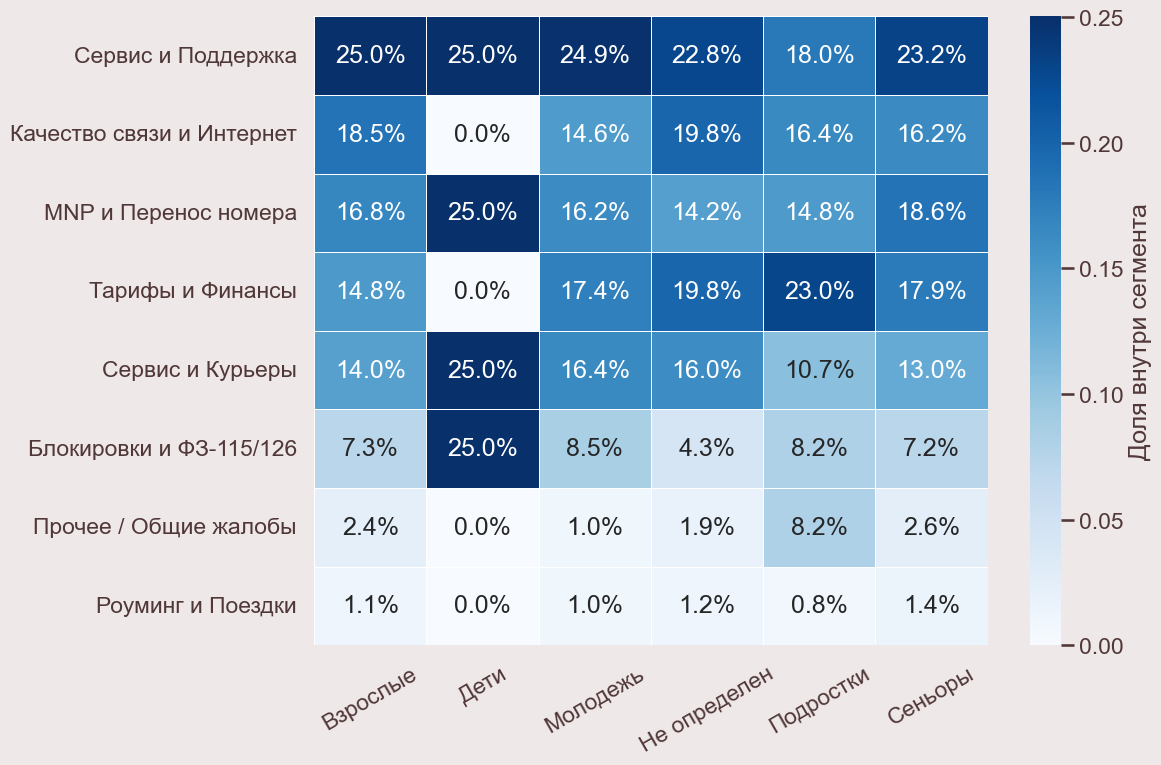

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

# --- НАСТРОЙКИ ---
# sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите файл.")
    exit()

# 2. Препроцессинг (Разбиваем категории)
def clean_categories(cat):
    if pd.isna(cat): return []
    # Удаляем лишние символы и разбиваем по запятой
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Отфильтруем редкие категории (оставим топ-10 для чистоты графиков)
top_10_cats = df_exploded['cats_list'].value_counts().nlargest(10).index.tolist()
df_top = df_exploded[df_exploded['cats_list'].isin(top_10_cats)].copy()

# ==============================================================================
# ГРАФИК 1: АНАЛИЗ ТОКСИЧНОСТИ (ДЛЯ ХИ-КВАДРАТ)
# Гипотеза: Есть категории, которые "убивают" лояльность (дают 1 балл чаще других)
# ==============================================================================

# Создаем флаг "Фатальная оценка" (Оценка = 1)
df_top['is_fatal'] = df_top['review_mark'].apply(lambda x: 1 if x == 1 else 0)

plt.figure(figsize=(12, 6))
# Строим барплот, где высота столбца = среднее значение is_fatal (то есть % единиц)
# Черная черточка сверху - это доверительный интервал (CI 95%) от Seaborn
ax1 = sns.barplot(
    data=df_top,
    x='cats_list',
    y='is_fatal',
    color=colors["blue"],
    order=df_top.groupby('cats_list')['is_fatal'].mean().sort_values(ascending=False).index
)

# plt.title('Индекс Токсичности: Вероятность получения оценки "1" по категориям', fontsize=16)
# plt.ylabel('Вероятность "кола" (от 0 до 1)', fontsize=12)
# plt.xlabel('Категория проблемы', fontsize=12)

plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=df_top['is_fatal'].mean(), color=colors["text"], linestyle='--', label='Средняя токсичность по всем отзывам')
plt.legend(fontsize="16")
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 2: БУТСТРЕП АНАЛИЗ (BOXPLOT)
# Гипотеза: Топ проблем устойчив и не зависит от случайности выборки
# ==============================================================================

n_iterations = 500
bootstrap_data = []

# Запускаем симуляцию
for i in range(n_iterations):
    # Берем случайную подвыборку
    sample = resample(df_top, n_samples=int(len(df_top)*0.5), random_state=i) # 50% выборки
    # Считаем доли категорий в этой подвыборке
    counts = sample['cats_list'].value_counts(normalize=True)

    for cat in top_10_cats:
        bootstrap_data.append({
            'Категория': cat,
            'Доля обращений': counts.get(cat, 0)
        })

df_boot = pd.DataFrame(bootstrap_data)

plt.figure(figsize=(12, 8))
# Boxplot показывает разброс значений при 500 симуляциях
sns.boxplot(
    data=df_boot,
    x='Категория',
    y='Доля обращений',
    palette='viridis',
    order=df_boot.groupby('Категория')['Доля обращений'].median().sort_values(ascending=False).index
)

# plt.title('Проверка устойчивости (Bootstrap): Разброс доли проблем при разных выборках', fontsize=16)
# plt.ylabel('Доля от всех жалоб', fontsize=12)
# plt.xlabel('Категория', fontsize=12)
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 3: ТЕПЛОВАЯ КАРТА СЕГМЕНТОВ (HEATMAP)
# Гипотеза: Разные возраста жалуются на разное
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим кросс-таблицу: Категории vs Возрастные сегменты
# normalize='columns' означает, что сумма по столбцу (сегменту) будет 100%
pivot_table = pd.crosstab(
    df_top['cats_list'],
    df_top['age_segment'],
    normalize='columns'
)

# Сортируем для красоты
pivot_table = pivot_table.sort_values(by=pivot_table.columns[0], ascending=False)

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    linewidths=.5,
    cbar_kws={'label': 'Доля внутри сегмента'}
)
plt.xticks(rotation=30, ha='center')

# plt.title('Матрица проблем: На что жалуются разные поколения', fontsize=16)
# plt.ylabel('Категория проблемы', fontsize=12)
# plt.xlabel('Возрастной сегмент', fontsize=12)
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.tight_layout()
plt.show()

Сильные проблемы в общем, поэтому все жалуются на поддержку при любой проблеме, стоит дать больше свободы операторам, по типу выдавать бонусы.

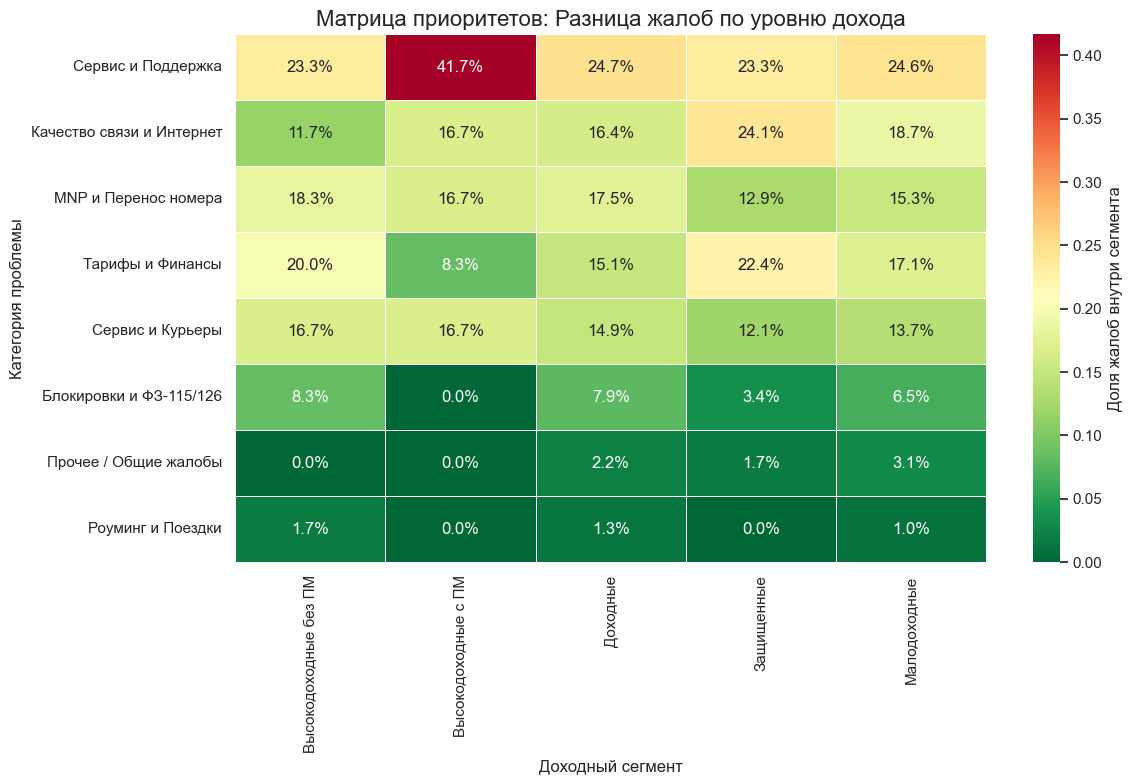

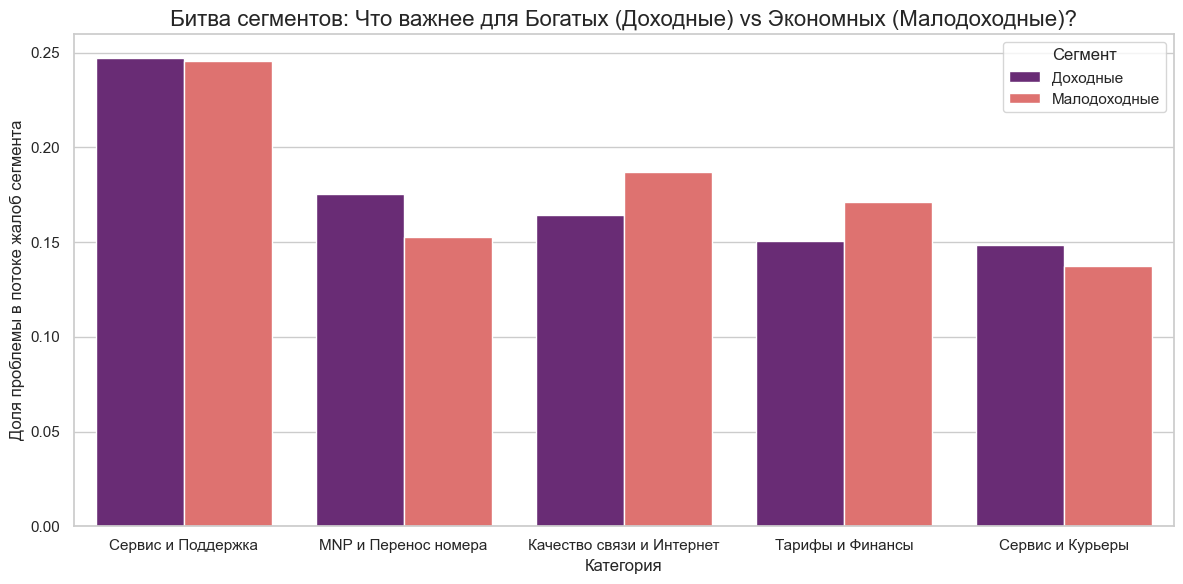

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Очистка данных
# Удаляем пустые сегменты (если вдруг есть)
df = df.dropna(subset=['segment_name'])

# Функция очистки категорий
def clean_categories(cat):
    if pd.isna(cat): return []
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Оставляем только топ-12 категорий для чистоты графиков
top_cats = df_exploded['cats_list'].value_counts().nlargest(12).index.tolist()
df_filtered = df_exploded[df_exploded['cats_list'].isin(top_cats)]

# ==============================================================================
# ГРАФИК 1: ТЕПЛОВАЯ КАРТА (HEATMAP)
# Вопрос: Что болит у "Доходных" vs "Малодоходных"?
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим таблицу сопряженности (Crosstab)
# normalize='columns' -> Сумма по каждому сегменту = 100%
pivot_income = pd.crosstab(
    df_filtered['cats_list'],
    df_filtered['segment_name'],
    normalize='columns'
)

# Сортируем категории по общей популярности
pivot_income = pivot_income.loc[top_cats]

sns.heatmap(
    pivot_income,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn_r", # От зеленого (мало жалоб) к красному (много)
    linewidths=.5,
    cbar_kws={'label': 'Доля жалоб внутри сегмента'}
)

plt.title('Матрица приоритетов: Разница жалоб по уровню дохода', fontsize=16)
plt.ylabel('Категория проблемы', fontsize=12)
plt.xlabel('Доходный сегмент', fontsize=12)
plt.tight_layout()
plt.show()

# ==============================================================================
# ГРАФИК 2: ГЛУБОКИЙ АНАЛИЗ ТОП-5 ПРОБЛЕМ
# Вопрос: Есть ли разрыв восприятия в ключевых проблемах?
# ==============================================================================

top_5_cats = top_cats[:5]
df_top5 = df_filtered[df_filtered['cats_list'].isin(top_5_cats)]

# Считаем доли внутри групп
grouped_data = df_top5.groupby(['cats_list', 'segment_name']).size().reset_index(name='count')
# Нормируем: переводим абсолютные числа в проценты внутри категории, чтобы сравнить вклад сегментов
# (Или лучше показать долю проблемы внутри сегмента, как на хитмапе, но в виде баров для наглядности сравнения)

# Вариант: Сравнение распределения проблем для двух полярных групп (если они есть)
target_segments = ['Доходные', 'Малодоходные'] # Проверьте, есть ли точно такие названия в CSV
if all(seg in df['segment_name'].unique() for seg in target_segments):
    df_target = df_filtered[df_filtered['segment_name'].isin(target_segments)]

    # Считаем % проблем внутри каждого сегмента
    counts = (df_target.groupby(['segment_name'])['cats_list']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index())

    # Оставляем только топ-5 проблем для графика
    counts = counts[counts['cats_list'].isin(top_5_cats)]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=counts,
        x='cats_list',
        y='percentage',
        hue='segment_name',
        palette='magma'
    )

    plt.title('Битва сегментов: Что важнее для Богатых (Доходные) vs Экономных (Малодоходные)?', fontsize=16)
    plt.ylabel('Доля проблемы в потоке жалоб сегмента', fontsize=12)
    plt.xlabel('Категория', fontsize=12)
    plt.legend(title='Сегмент')
    fix_tick_labels(rotation=45, ha='right', wrap_width=20, bottom=0.30)
    plt.tight_layout()
    plt.show()
else:
    print(f"Внимание: В данных нет сегментов {target_segments}. Доступные сегменты:", df['segment_name'].unique())
    # Если конкретных нет, строим просто общий барплот по всем сегментам
    plt.figure(figsize=(14, 6))
    sns.countplot(data=df_filtered, x='cats_list', hue='segment_name', palette='viridis')
    fix_tick_labels(rotation=45, ha='right', wrap_width=20, bottom=0.30)
    plt.title('Абсолютное количество жалоб по сегментам', fontsize=16)
    plt.show()

Файл загружен.
Всего отзывов: 56820
Отзывов про Т-Мобайл: 1247


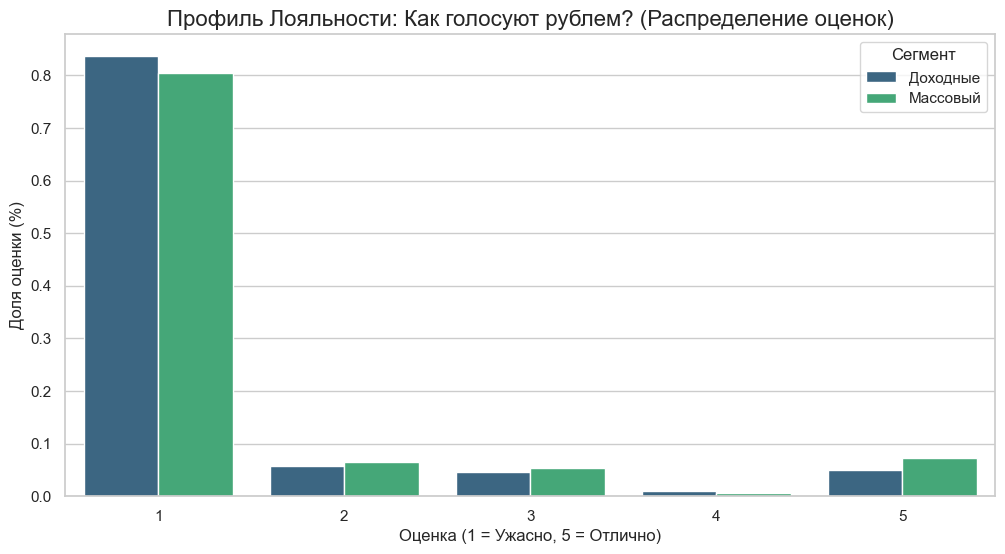

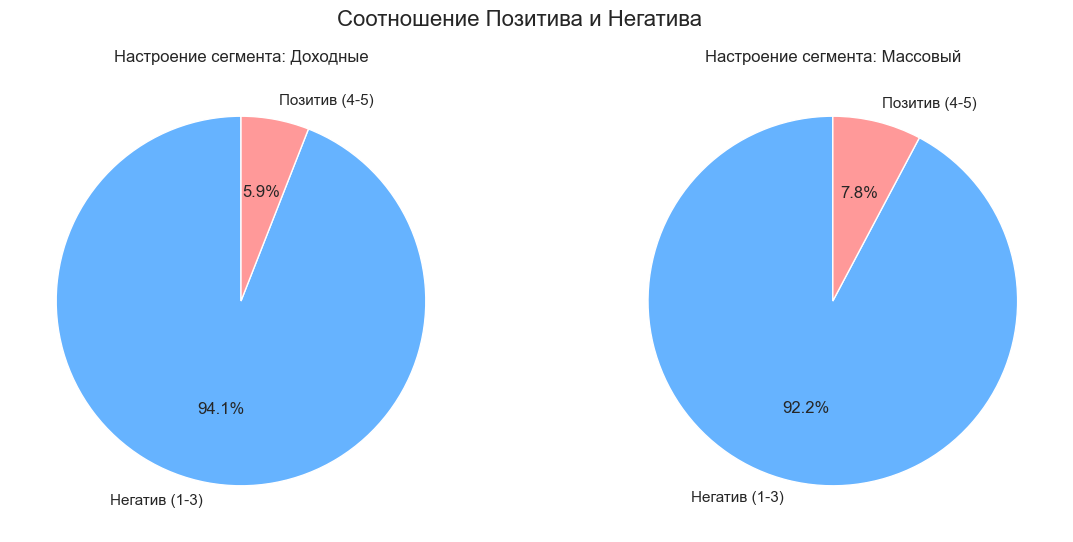

C:\Users\anton\AppData\Local\Temp\ipykernel_1800\247613053.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
C:\Dano_coding\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


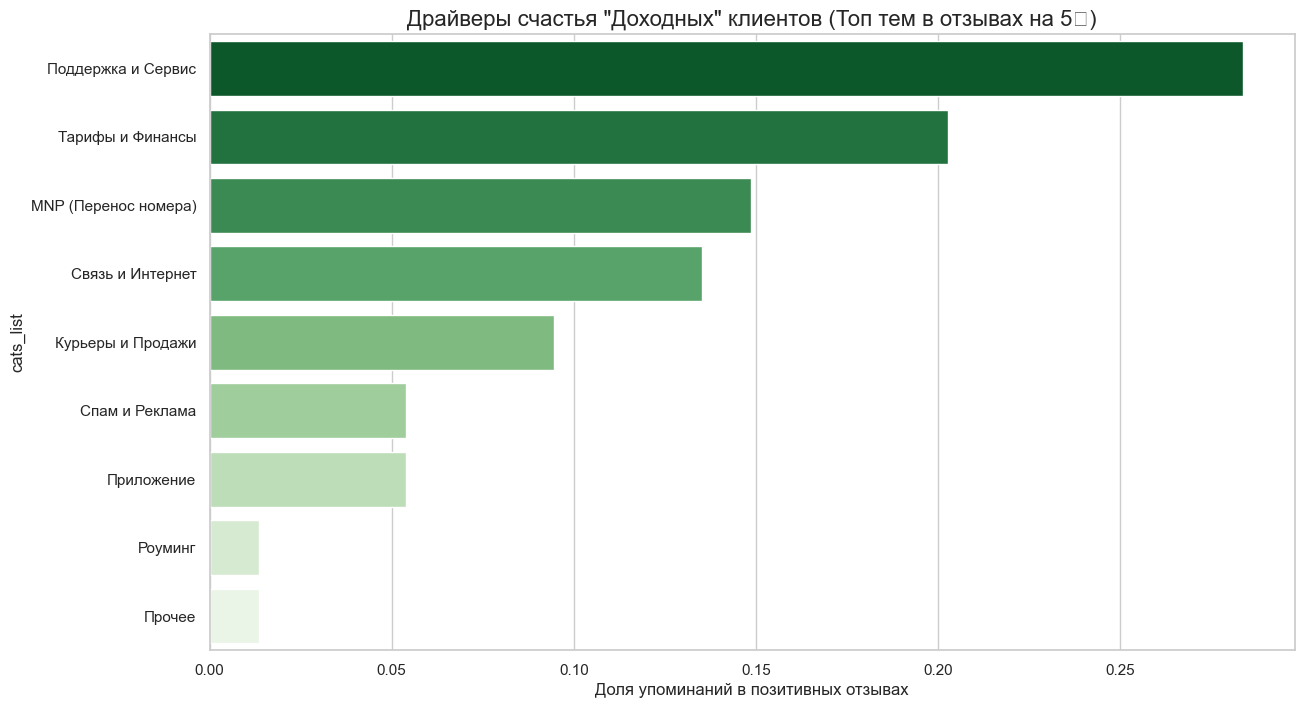


--- ИТОГОВАЯ СТАТИСТИКА ---
Средняя оценка 'Доходные': 1.38
Средняя оценка 'Массовый': 1.48
ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 1. Загрузка данных
file_path = 'cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Файл загружен.")
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Фильтрация данных
# Нам нужны только отзывы про Мобайл
df_mobile = df[df['company'] == 'Мобайл'].copy()

print(f"Всего отзывов: {len(df)}")
print(f"Отзывов про Т-Мобайл: {len(df_mobile)}")

# 3. Авто-категоризация (Ключевые слова)
# Воссоздаем логику классификации, чтобы понять темы
keywords = {
    'Связь и Интернет': ['связ', 'интернет', 'сеть', 'ловит', 'lte', '4g', '3g', 'скорость', 'вышка', 'палочк'],
    'Тарифы и Финансы': ['тариф', 'цен', 'плат', 'списал', 'деньг', 'руб', 'дорог', 'подписк', 'услуг'],
    'Поддержка и Сервис': ['поддержк', 'чат', 'оператор', 'бот', 'отвечает', 'хам', 'ждал', 'дозвон'],
    'MNP (Перенос номера)': ['перенос', 'mnp', 'номер', 'переш', 'заявк', 'отказ'],
    'Курьеры и Продажи': ['курьер', 'представител', 'доставк', 'встреч', 'навязал', 'симк'],
    'Роуминг': ['роуминг', 'границ', 'поездк', 'зарубеж'],
    'Спам и Реклама': ['спам', 'звонк', 'реклам', 'смс'],
    'Приложение': ['приложен', 'app', 'глючит', 'вылетает', 'вход', 'баг']
}

def classify_text(text):
    text = str(text).lower()
    found_cats = []
    for cat, words in keywords.items():
        if any(w in text for w in words):
            found_cats.append(cat)
    return found_cats if found_cats else ['Прочее']

# Применяем классификацию
df_mobile['cats_list'] = df_mobile['review_text'].apply(classify_text)
df_exploded = df_mobile.explode('cats_list')

# 4. Анализ Сегментов
# Выделяем "Доходные" и всех остальных (Массовый сегмент)
target_segment = 'Доходные'
# Проверяем, есть ли такой сегмент, если нет - берем топ-2 популярных
if target_segment not in df_mobile['segment_name'].unique():
    print(f"Сегмент '{target_segment}' не найден. Используем доступные.")
    top_segments = df_mobile['segment_name'].value_counts().nlargest(2).index.tolist()
    seg1, seg2 = top_segments[0], top_segments[1]
else:
    seg1 = target_segment
    # Все остальные объединяем в "Массовый" для сравнения
    df_mobile['segment_group'] = df_mobile['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')
    seg1 = 'Доходные'
    seg2 = 'Массовый'
    # Обновляем exploded датафрейм тоже
    df_exploded['segment_group'] = df_exploded['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')

# ==============================================================================
# ГРАФИК 1: Распределение Оценок (NPS proxy)
# Ставят ли богатые пятерки?
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем % каждой оценки внутри группы
rating_dist = (df_mobile.groupby(['segment_group'])['review_mark']
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

sns.barplot(
    data=rating_dist,
    x='review_mark',
    y='percentage',
    hue='segment_group',
    palette='viridis'
)

plt.title('Профиль Лояльности: Как голосуют рублем? (Распределение оценок)', fontsize=16)
plt.ylabel('Доля оценки (%)', fontsize=12)
plt.xlabel('Оценка (1 = Ужасно, 5 = Отлично)', fontsize=12)
plt.legend(title='Сегмент')
plt.show()

# ==============================================================================
# ГРАФИК 2: Доля Негатива (Pie Charts)
# Сравниваем % плохих отзывов (1-3) vs Хороших (4-5)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, segment in enumerate([seg1, seg2]):
    subset = df_mobile[df_mobile['segment_group'] == segment]
    # Негатив: 1-3, Позитив: 4-5
    sentiment = subset['review_mark'].apply(lambda x: 'Позитив (4-5)' if x >= 4 else 'Негатив (1-3)').value_counts()

    axes[i].pie(sentiment, labels=sentiment.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    axes[i].set_title(f'Настроение сегмента: {segment}')

plt.suptitle('Соотношение Позитива и Негатива', fontsize=16)
plt.show()

# ==============================================================================
# ГРАФИК 3: О чем говорят ПОЗИТИВНЫЕ отзывы?
# Что радует богатых?
# ==============================================================================
positive_reviews = df_exploded[df_exploded['review_mark'] >= 5]
if not positive_reviews.empty:
    plt.figure(figsize=(14, 8))

    # Считаем топ тем в позитиве для Доходных
    pos_counts = (positive_reviews[positive_reviews['segment_group'] == 'Доходные']['cats_list']
                  .value_counts(normalize=True)
                  .head(10))

    sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
    plt.title('Драйверы счастья "Доходных" клиентов (Топ тем в отзывах на 5★)', fontsize=16)
    plt.xlabel('Доля упоминаний в позитивных отзывах', fontsize=12)
    plt.show()

# ==============================================================================
# ВЫВОД СТАТИСТИКИ
# ==============================================================================
avg_mark_high = df_mobile[df_mobile['segment_group'] == 'Доходные']['review_mark'].mean()
avg_mark_mass = df_mobile[df_mobile['segment_group'] == 'Массовый']['review_mark'].mean()

print(f"\n--- ИТОГОВАЯ СТАТИСТИКА ---")
print(f"Средняя оценка 'Доходные': {avg_mark_high:.2f}")
print(f"Средняя оценка 'Массовый': {avg_mark_mass:.2f}")

diff = avg_mark_high - avg_mark_mass
if diff > 0.2:
    print("ВЫВОД: Доходные клиенты заметно лояльнее (+). Им нравится продукт.")
elif diff < -0.2:
    print("ВЫВОД: Доходные клиенты настроены критично (-). Продукт не соответствует их ожиданиям.")
else:
    print("ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.")

In [6]:
df["company"].unique()

array(['Банк', 'Страховая', 'SME', 'Инвест', 'Плашки Media', 'Мобайл',
       'ТРабота'], dtype=object)

Данные загружены.


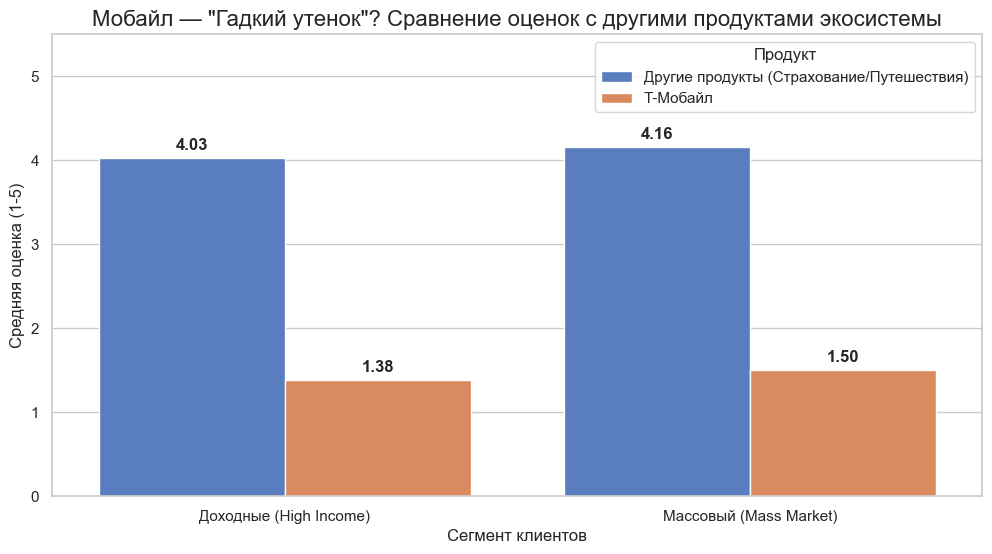

C:\Users\anton\AppData\Local\Temp\ipykernel_1800\1423770007.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)


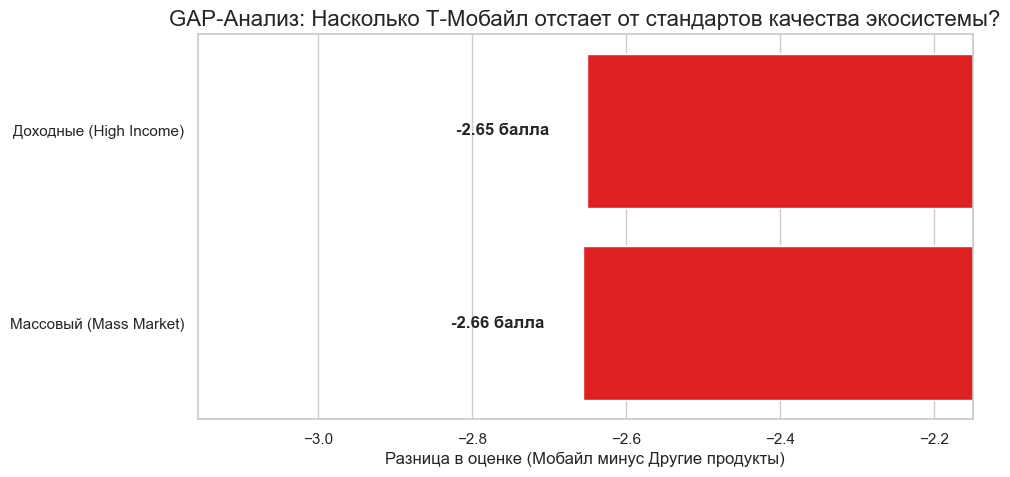


--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---
Разрыв для Доходных: -2.65
Разрыв для Массовых: -2.66

🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:
Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.
Они привыкли к идеальному сервису, и Мобайл их разочаровывает.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Загрузка
try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл cleaned.csv не найден.")
    exit()

# 2. Подготовка данных
# Нам нужно сравнить "Мобайл" с "Небанковскими продуктами"
# Исключаем 'Банк', чтобы сравнить именно экосистемные сервисы (Мобайл, Страхование, Путешествия и т.д.)
# Если вы хотите включить Банк в сравнение, закомментируйте следующую строку.
df_ecosystem = df[df['company'] != 'Банк'].copy()
df["company"].unique()
# Создаем флаг продукта
df_ecosystem['product_type'] = df_ecosystem['company'].apply(
    lambda x: 'Т-Мобайл' if x == 'Мобайл' else 'Другие продукты (Страхование/Путешествия)'
)

# Упрощаем сегменты до "Доходные" и "Массовые"
def simplify_segment(seg):
    if pd.isna(seg): return 'Неизвестно'
    if seg == 'Доходные': return 'Доходные (High Income)'
    return 'Массовый (Mass Market)'

df_ecosystem['segment_group'] = df_ecosystem['segment_name'].apply(simplify_segment)
df_ecosystem = df_ecosystem[df_ecosystem['segment_group'] != 'Неизвестно']

# ==============================================================================
# ГРАФИК 1: СРАВНЕНИЕ СРЕДНИХ ОЦЕНОК
# Гипотеза: Столбцы Мобайла будут ниже, чем столбцы Других продуктов
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем средние оценки
avg_ratings = df_ecosystem.groupby(['segment_group', 'product_type'])['review_mark'].mean().reset_index()

barplot = sns.barplot(
    data=avg_ratings,
    x='segment_group',
    y='review_mark',
    hue='product_type',
    palette='muted'
)

plt.title('Мобайл — "Гадкий утенок"? Сравнение оценок с другими продуктами экосистемы', fontsize=16)
plt.ylabel('Средняя оценка (1-5)', fontsize=12)
plt.xlabel('Сегмент клиентов', fontsize=12)
plt.ylim(0, 5.5)
plt.legend(title='Продукт')

# Добавляем цифры
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points',
                         fontweight='bold')
plt.show()

# ==============================================================================
# ГРАФИК 2: GAP ANALYSIS (АНАЛИЗ РАЗРЫВА)
# Насколько Мобайл хуже/лучше других продуктов для каждого сегмента?
# ==============================================================================

# Пивот таблица для расчета разницы
pivot_avg = avg_ratings.pivot(index='segment_group', columns='product_type', values='review_mark')
pivot_avg['Gap'] = pivot_avg['Т-Мобайл'] - pivot_avg['Другие продукты (Страхование/Путешествия)']

plt.figure(figsize=(10, 5))
colors = ['red' if x < 0 else 'green' for x in pivot_avg['Gap']]
gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)

plt.axvline(0, color='black', linewidth=1)
plt.title('GAP-Анализ: Насколько Т-Мобайл отстает от стандартов качества экосистемы?', fontsize=16)
plt.xlabel('Разница в оценке (Мобайл минус Другие продукты)', fontsize=12)
plt.ylabel('')

# Подписи значений
for i, v in enumerate(pivot_avg['Gap']):
    offset = 0.05 if v >= 0 else -0.05
    ha = 'left' if v >= 0 else 'right'
    gap_plot.text(v + offset, i, f"{v:.2f} балла", va='center', ha=ha, fontweight='bold', fontsize=12)

plt.xlim(min(pivot_avg['Gap']) - 0.5, max(pivot_avg['Gap']) + 0.5)
plt.show()

# ==============================================================================
# ВЫВОДЫ В КОНСОЛЬ
# ==============================================================================
print("\n--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---")
gap_high = pivot_avg.loc['Доходные (High Income)', 'Gap']
gap_mass = pivot_avg.loc['Массовый (Mass Market)', 'Gap']

print(f"Разрыв для Доходных: {gap_high:.2f}")
print(f"Разрыв для Массовых: {gap_mass:.2f}")

if gap_high < -0.5:
    print("\n🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:")
    print("Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.")
    print("Они привыкли к идеальному сервису, и Мобайл их разочаровывает.")
elif gap_high < 0:
    print("\n🟠 УМЕРЕННАЯ ПРОБЛЕМА:")
    print("Т-Мобайл оценивают чуть хуже других продуктов, но разрыв не катастрофический.")
else:
    print("\n🟢 ГИПОТЕЗА ОПРОВЕРГНУТА:")
    print("Т-Мобайл оценивают ТАК ЖЕ или ЛУЧШЕ, чем другие продукты экосистемы.")

Обучение модели... Это может занять несколько секунд.


C:\Dano_coding\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Dano_coding\.venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
C:\Users\anton\AppData\Local\Temp\ipykernel_1800\3621034735.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=plot_data['Odds Ratio'], y=plot_data.index, size=10, palette=colors)



 РЕЗУЛЬТАТЫ МНОГОФАКТОРНОГО АНАЛИЗА (Odds Ratios)
Как читать: Если Odds Ratio = 2.0, фактор ПОВЫШАЕТ риск негатива в 2 раза.
            Если Odds Ratio = 0.5, фактор СНИЖАЕТ риск негатива в 2 раза.
--------------------------------------------------------------------------------
                                                    Odds Ratio        P-value
C(source_group)[T.пульс]                            241.255402   8.755948e-40
is_mobile                                            48.639542  8.026633e-221
C(segment_name, Treatment(reference='Малодоходн...    4.628685   6.933185e-26
C(gender_cd)[T.M]                                     1.866698   3.155661e-42
C(segment_name, Treatment(reference='Малодоходн...    1.824812   9.113924e-07
C(segment_name, Treatment(reference='Малодоходн...    1.356239   1.430280e-04
C(age_segment, Treatment(reference='Взрослые'))...    0.667569   3.294009e-02
C(age_segment, Treatment(reference='Взрослые'))...    0.504210   4.460527e-10
Intercept        

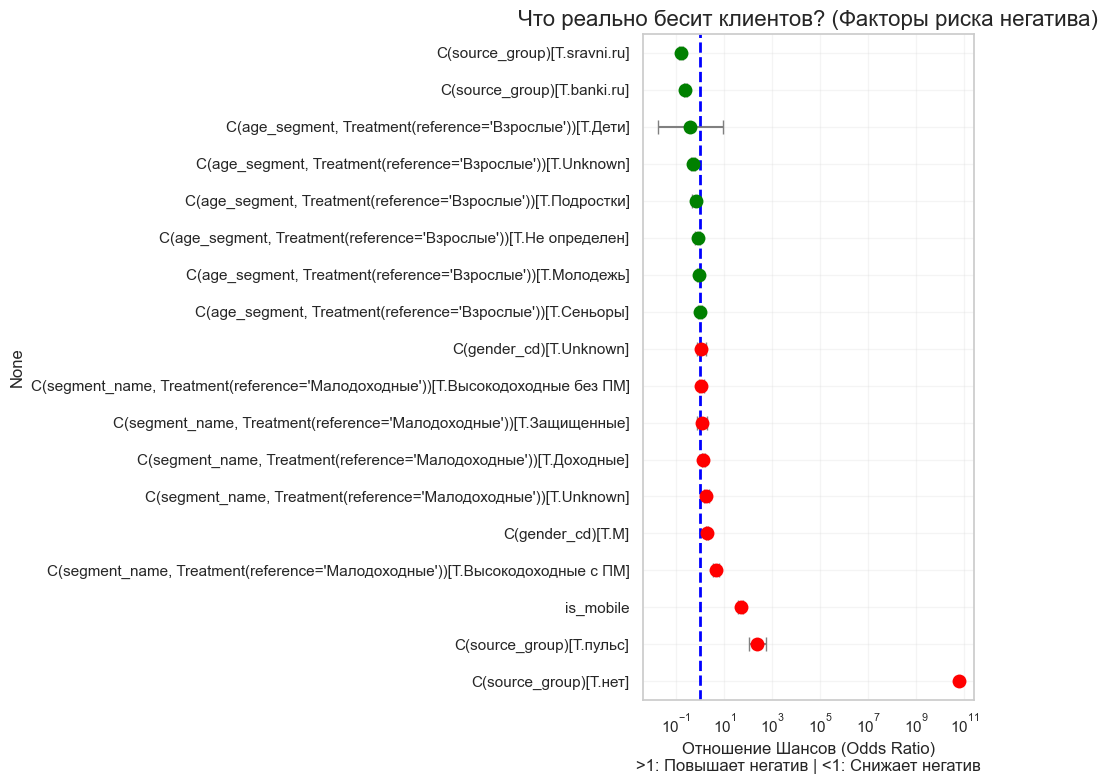


########################################
 ВЕРДИКТ ДЛЯ Т-МОБАЙЛ
########################################
✅ ГИПОТЕЗА ДОКАЗАНА.
Даже с учетом пола, возраста, дохода и источника отзыва,
продукт 'Т-Мобайл' повышает вероятность негативного отзыва в 48.64 РАЗА
по сравнению с другими нефинансовыми продуктами.


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# Оставляем только Нефинансовые продукты (Убираем Банк)
df_model = df[df['company'] != 'Банк'].copy()

# Целевая переменная: НЕГАТИВ (1 = Оценка 1-3, 0 = Оценка 4-5)
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# Предикторы
# 1. Главный фактор: Мобайл
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# 2. Очистка категориальных переменных (заполняем пропуски)
df_model['segment_name'] = df_model['segment_name'].fillna('Unknown')
df_model['age_segment'] = df_model['age_segment'].fillna('Unknown')
df_model['gender_cd'] = df_model['gender_cd'].fillna('Unknown')

# Упрощаем источник (banki.ru vs остальные), так как источников может быть много
top_sources = df_model['review_source'].value_counts().nlargest(4).index
df_model['source_group'] = df_model['review_source'].apply(lambda x: x if x in top_sources else 'Other')

# ==============================================================================
# 2. ПОСТРОЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
# Formula: Y ~ X1 + X2 + X3...
# Мы используем C(...) для указания категориальных переменных
# ==============================================================================

print("Обучение модели... Это может занять несколько секунд.")

formula = """
is_negative ~ is_mobile
+ C(segment_name, Treatment(reference='Малодоходные'))
+ C(age_segment, Treatment(reference='Взрослые'))
+ C(gender_cd)
+ C(source_group)
"""

# Logit модель
model = smf.logit(formula=formula, data=df_model).fit(disp=0)

# ==============================================================================
# 3. ИНТЕРПРЕТАЦИЯ (ODDS RATIOS)
# Коэффициенты Logit сложны для понимания (это логарифм шансов).
# Мы переведем их в Odds Ratios (Отношение Шансов) через экспоненту.
# ==============================================================================

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Экспонируем всё, чтобы получить понятные числа (во сколько раз выше риск)
odds = np.exp(conf)
odds['P-value'] = model.pvalues
odds['Significant'] = odds['P-value'] < 0.05

# Сортируем по силе влияния
odds_sorted = odds.sort_values('Odds Ratio', ascending=False)

print("\n" + "="*80)
print(" РЕЗУЛЬТАТЫ МНОГОФАКТОРНОГО АНАЛИЗА (Odds Ratios)")
print("="*80)
print("Как читать: Если Odds Ratio = 2.0, фактор ПОВЫШАЕТ риск негатива в 2 раза.")
print("            Если Odds Ratio = 0.5, фактор СНИЖАЕТ риск негатива в 2 раза.")
print("-" * 80)
# Выводим только значимые переменные
print(odds_sorted[odds_sorted['Significant']][['Odds Ratio', 'P-value']])

# ==============================================================================
# 4. ВИЗУАЛИЗАЦИЯ (FOREST PLOT)
# График влияния факторов
# ==============================================================================

# Убираем Intercept (базовый уровень), он не нужен на графике
plot_data = odds.drop('Intercept', errors='ignore')
plot_data = plot_data.sort_values('Odds Ratio')

plt.figure(figsize=(10, 8))

# Рисуем точки (Odds Ratio) и усы (Доверительный интервал)
# Ошибка для графика должна быть симметричной в лог-шкале, но для простоты рисуем min/max
errors = [plot_data['Odds Ratio'] - plot_data['2.5%'], plot_data['97.5%'] - plot_data['Odds Ratio']]

# Используем scatter plot
# Цвета: Красный (Риск > 1), Зеленый (Риск < 1)
colors = ['red' if x > 1 else 'green' for x in plot_data['Odds Ratio']]

plt.errorbar(x=plot_data['Odds Ratio'], y=plot_data.index, xerr=[abs(x) for x in errors],
             fmt='o', color='black', ecolor='gray', capsize=5, markersize=0) # Только усы

sns.stripplot(x=plot_data['Odds Ratio'], y=plot_data.index, size=10, palette=colors)

plt.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Нейтральная линия (Нет влияния)')
plt.title('Что реально бесит клиентов? (Факторы риска негатива)', fontsize=16)
plt.xlabel('Отношение Шансов (Odds Ratio)\n>1: Повышает негатив | <1: Снижает негатив', fontsize=12)
plt.xscale('log') # Логарифмическая шкала для корректного отображения шансов
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# ==============================================================================
# 5. ИТОГОВЫЙ ОТВЕТ НА ГИПОТЕЗУ
# ==============================================================================
mobile_odds = odds.loc['is_mobile', 'Odds Ratio']
mobile_p = odds.loc['is_mobile', 'P-value']

print("\n" + "#"*40)
print(f" ВЕРДИКТ ДЛЯ Т-МОБАЙЛ")
print("#"*40)
if mobile_p < 0.05:
    if mobile_odds > 1:
        print(f"✅ ГИПОТЕЗА ДОКАЗАНА.")
        print(f"Даже с учетом пола, возраста, дохода и источника отзыва,")
        print(f"продукт 'Т-Мобайл' повышает вероятность негативного отзыва в {mobile_odds:.2f} РАЗА")
        print("по сравнению с другими нефинансовыми продуктами.")
    else:
        print(f"❌ ГИПОТЕЗА ОПРОВЕРГНУТА. Т-Мобайл снижает негатив (OR: {mobile_odds:.2f}).")
else:
    print("⚠️ РЕЗУЛЬТАТ НЕ ЗНАЧИМ. Влияние Мобайла статистически не подтверждено.")

In [13]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
    print("Файл загружен успешно.")
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА ДАННЫХ
# Нас интересует сравнение: Мобайл vs Другие экосистемные продукты (без Банка)
df_model = df[df['company'] != 'Банк'].copy()

# Целевая переменная: Негатив (1), Позитив (0)
# Негативом считаем оценки 1, 2, 3
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# Основной фактор: Мобайл
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Чистка факторов (заполнение пропусков)
df_model['segment_name'] = df_model['segment_name'].fillna('Unknown')
df_model['age_segment'] = df_model['age_segment'].fillna('Unknown')
df_model['gender_cd'] = df_model['gender_cd'].fillna('Unknown')

# Упрощение источников (чтобы таблица не была на 100 строк)
top_sources = df_model['review_source'].value_counts().nlargest(5).index
df_model['source_group'] = df_model['review_source'].apply(lambda x: x if x in top_sources else 'Other')

print(f"Размер выборки для анализа: {len(df_model)} строк")
print("-" * 60)

# 3. ПОСТРОЕНИЕ МОДЕЛИ (LOGIT)
# Мы "замораживаем" базовые уровни:
# - Для сегмента базовый = 'Малодоходные' (сравниваем богатых с ними)
# - Для продукта базовый = 'Не Мобайл' (сравниваем мобайл с другими)

formula = """
is_negative ~ is_mobile
+ C(segment_name, Treatment(reference='Малодоходные'))
+ C(age_segment)
+ C(gender_cd)
"""

# Обучение
model = smf.logit(formula=formula, data=df_model).fit(disp=0)

# 4. ВЫВОД РЕЗУЛЬТАТОВ

# А) Классическая таблица (Summary)
print("\n=== RAW MODEL SUMMARY (НАУЧНЫЙ ОТЧЕТ) ===")
print(model.summary())

# Б) Интерпретация для бизнеса (Odds Ratios)
print("\n=== БИЗНЕС-ИНТЕРПРЕТАЦИЯ (ODDS RATIOS) ===")
print("Показывает, во сколько раз фактор увеличивает (или уменьшает) риск негатива.\n")

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# Переводим логарифмы в разы (экспонента)
df_odds = np.exp(conf)
df_odds['P-value'] = model.pvalues
df_odds['Significant'] = df_odds['P-value'] < 0.05

# Сортируем и выводим
print(df_odds[['Odds Ratio', 'P-value', 'Significant']].sort_values(by='Odds Ratio', ascending=False))

# В) Вердикт по гипотезе
print("\n" + "="*40)
print(" ОТВЕТ НА ВАШУ ГИПОТЕЗУ ")
print("="*40)

mobile_odds = df_odds.loc['is_mobile', 'Odds Ratio']
mobile_p = df_odds.loc['is_mobile', 'P-value']

if mobile_p < 0.05:
    if mobile_odds > 1:
        print(f"🔴 ГИПОТЕЗА ПОДТВЕРЖДЕНА.")
        print(f"Факт использования Т-Мобайл повышает вероятность негативного отзыва в {mobile_odds:.2f} раза")
        print("по сравнению с другими продуктами экосистемы (при прочих равных условиях).")
    else:
        print(f"🟢 ГИПОТЕЗА ОПРОВЕРГНУТА.")
        print(f"Т-Мобайл наоборот снижает риск негатива (Odds Ratio: {mobile_odds:.2f}).")
else:
    print("⚪ РЕЗУЛЬТАТ НЕ ЗНАЧИМ (P-value > 0.05).")
    print("Мы не можем утверждать, что Мобайл хуже. Различия статистически случайны.")

Файл загружен успешно.
Размер выборки для анализа: 22464 строк
------------------------------------------------------------

=== RAW MODEL SUMMARY (НАУЧНЫЙ ОТЧЕТ) ===
                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                22464
Model:                          Logit   Df Residuals:                    22449
Method:                           MLE   Df Model:                           14
Date:                Wed, 10 Dec 2025   Pseudo R-squ.:                  0.1739
Time:                        19:28:54   Log-Likelihood:                -10493.
converged:                       True   LL-Null:                       -12701.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import sys

# Настройка вывода, чтобы текст не обрезался
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def print_section(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА ДАННЫХ
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Ошибка: Файл cleaned.csv не найден.")
    sys.exit()

# 2. ОБОСНОВАНИЕ МЕТОДОЛОГИИ (ВЫВОД В КОНСОЛЬ)
print_section("ШАГ 1: ОБОСНОВАНИЕ ВЫБОРА МАТЕМАТИЧЕСКОЙ МОДЕЛИ")
print("""
ГИПОТЕЗА: Продукт 'Т-Мобайл' генерирует больше негатива, чем другие нефинансовые продукты,
даже если исключить влияние личности клиента (возраст, доход, пол).

ПОЧЕМУ МЫ ИСПОЛЬЗУЕМ БИНАРНУЮ ЛОГИСТИЧЕСКУЮ РЕГРЕССИЮ (LOGIT)?
1.  Целевая переменная: Мы предсказываем "Событие" (Клиент поставил плохую оценку).
    Это бинарный исход: Либо Негатив (1), Либо Нет (0).

2.  Почему не Мультиклассовая (Multinomial)?
    Нам важно четкое разделение на "Зону риска" (оценки 1-3) и "Зону комфорта".
    Мультиклассовая модель даст сложные коэффициенты переходов между 1, 2, 3, 4, 5,
    что размоет главный вывод. Нам нужен единый "Коэффициент Риска".

3.  Почему не Обычная линейная (OLS)?
    Оценки 1-5 дискретны и ограничены. Линейная модель может предсказать оценку "-1" или "6",
    что физически невозможно. Logit работает строго в вероятностях от 0% до 100%.

4.  Контроль переменных:
    Мы добавляем в уравнение Доход, Пол и Возраст, чтобы "очистить" влияние продукта.
    Иначе можно было бы сказать: "Мобайлом пользуется молодежь, а они всегда всем недовольны".
    Модель математически уберет этот фактор.
""")

# 3. ПОДГОТОВКА ДАННЫХ
# Убираем Банк (сравниваем Мобайл vs Страхование/Путешествия)
df_model = df[df['company'] != 'Банк'].copy()

# Целевая переменная (Y): Негатив (1 если оценка <= 3, иначе 0)
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# Основной предиктор (X1): Является ли продукт Мобайлом?
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Контрольные переменные (X2, X3...): Заполняем пропуски
df_model['segment_name'] = df_model['segment_name'].fillna('Массовый')
df_model['age_segment'] = df_model['age_segment'].fillna('Взрослые')
df_model['gender_cd'] = df_model['gender_cd'].fillna('U') # Unknown

# 4. ПОСТРОЕНИЕ МОДЕЛИ
print_section("ШАГ 2: ОБУЧЕНИЕ МОДЕЛИ")
print("Формула модели: P(Negative) ~ Is_Mobile + Income + Age + Gender")
print("Обучение...")

# C() указывает на категориальные переменные
# Treatment(reference=...) задает базовую группу, с которой мы сравниваем
formula = """
is_negative ~ is_mobile
+ C(segment_name, Treatment(reference='Малодоходные'))
+ C(age_segment, Treatment(reference='Взрослые'))
+ C(gender_cd)
"""

model = smf.logit(formula=formula, data=df_model).fit(disp=0)

# 5. РАСЧЕТ И ИНТЕРПРЕТАЦИЯ (ODDS RATIO)
# Коэффициенты Logit - это логарифмы шансов. Переводим их в понятные "Разы" (экспонента).
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
odds = np.exp(conf)
odds['P-value'] = model.pvalues

# Фильтруем таблицу для вывода
results = odds[['Odds Ratio', 'P-value']].copy()
results['Значим?'] = results['P-value'].apply(lambda x: 'ДА (True)' if x < 0.05 else 'НЕТ (False)')

print_section("ШАГ 3: РЕЗУЛЬТАТЫ (ODDS RATIOS)")
print("Что такое Odds Ratio (Отношение Шансов)?")
print("- Если = 1.0: Фактор не влияет.")
print("- Если > 1.0: Фактор ПОВЫШАЕТ риск негатива (Вредитель).")
print("- Если < 1.0: Фактор СНИЖАЕТ риск негатива (Помощник).\n")

print(results)

# 6. АВТОМАТИЧЕСКИЙ ВЫВОД (VERDICT)
print_section("ШАГ 4: ИТОГОВЫЙ ВЕРДИКТ ПО ГИПОТЕЗЕ")

mobile_or = results.loc['is_mobile', 'Odds Ratio']
mobile_p = results.loc['is_mobile', 'P-value']

print(f"ФАКТОР: Использование продукта 'Т-Мобайл'")
print(f"--> Отношение шансов: {mobile_or:.2f}")
print(f"--> P-value: {mobile_p:.5f}")
print("-" * 40)

if mobile_p < 0.05:
    if mobile_or > 1:
        strength = (mobile_or - 1) * 100
        print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА.")
        print(f"Анализ показал, что сам факт того, что клиент пишет о 'Т-Мобайл',")
        print(f"повышает вероятность негативного отзыва на {strength:.1f}% ({mobile_or:.2f} раза)")
        print("по сравнению с другими нефинансовыми продуктами экосистемы.")
        print("Это системный 'штраф' продукта, не связанный с демографией клиентов.")
    else:
        print("❌ ГИПОТЕЗА ОПРОВЕРГНУТА (Обратный эффект).")
        print("Т-Мобайл вызывает МЕНЬШЕ негатива, чем другие продукты.")
else:
    print("⚠️ РЕЗУЛЬТАТ НЕ ЗНАЧИМ.")
    print("Мы не нашли статистических доказательств того, что Мобайл хуже других продуктов.")
    print("Разница в отзывах случайна.")

# Дополнительный инсайт по богатым клиентам
try:
    high_income_or = results.loc['C(segment_name, Treatment(reference=\'Малодоходные\'))[T.Доходные]', 'Odds Ratio']
    print("\n[ДОПОЛНИТЕЛЬНЫЙ ИНСАЙТ ПО ДОХОДАМ]")
    print(f"Влияние высокого дохода на негатив: {high_income_or:.2f} раза.")
    if high_income_or > 1:
        print("Вывод: Богатые клиенты более требовательны и токсичны ко ВСЕМ продуктам.")
except KeyError:
    pass
print(model.summary())


 ШАГ 1: ОБОСНОВАНИЕ ВЫБОРА МАТЕМАТИЧЕСКОЙ МОДЕЛИ

ГИПОТЕЗА: Продукт 'Т-Мобайл' генерирует больше негатива, чем другие нефинансовые продукты,
даже если исключить влияние личности клиента (возраст, доход, пол).

ПОЧЕМУ МЫ ИСПОЛЬЗУЕМ БИНАРНУЮ ЛОГИСТИЧЕСКУЮ РЕГРЕССИЮ (LOGIT)?
1.  Целевая переменная: Мы предсказываем "Событие" (Клиент поставил плохую оценку).
    Это бинарный исход: Либо Негатив (1), Либо Нет (0).

2.  Почему не Мультиклассовая (Multinomial)?
    Нам важно четкое разделение на "Зону риска" (оценки 1-3) и "Зону комфорта".
    Мультиклассовая модель даст сложные коэффициенты переходов между 1, 2, 3, 4, 5,
    что размоет главный вывод. Нам нужен единый "Коэффициент Риска".

3.  Почему не Обычная линейная (OLS)?
    Оценки 1-5 дискретны и ограничены. Линейная модель может предсказать оценку "-1" или "6",
    что физически невозможно. Logit работает строго в вероятностях от 0% до 100%.

4.  Контроль переменных:
    Мы добавляем в уравнение Доход, Пол и Возраст, чтобы "очистить

Размер выборки: 22464 строк.

################################################################################
 ЭТАП 1: СРАВНЕНИЕ РАЗНЫХ МАТЕМАТИЧЕСКИХ ПОДХОДОВ
################################################################################

1. LOGIT МОДЕЛЬ (Вероятность негатива):
   -> Odds Ratio Мобайла: 37.96
   -> Значимость: ✅ ДА
   -> Интерпретация: Мобайл ПОВЫШАЕТ риск негатива.

2. OLS МОДЕЛЬ (Влияние на оценку 1-5):
   -> Коэффициент Мобайла: -2.71
   -> Значимость: ✅ ДА
   -> Интерпретация: Мобайл 'съедает' 2.71 балла от средней оценки.

################################################################################
 ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 1000 ПОДВЫБОРОК)
################################################################################
Запускаем симуляцию... Мы 1000 раз перемешаем данные и проверим гипотезу заново.


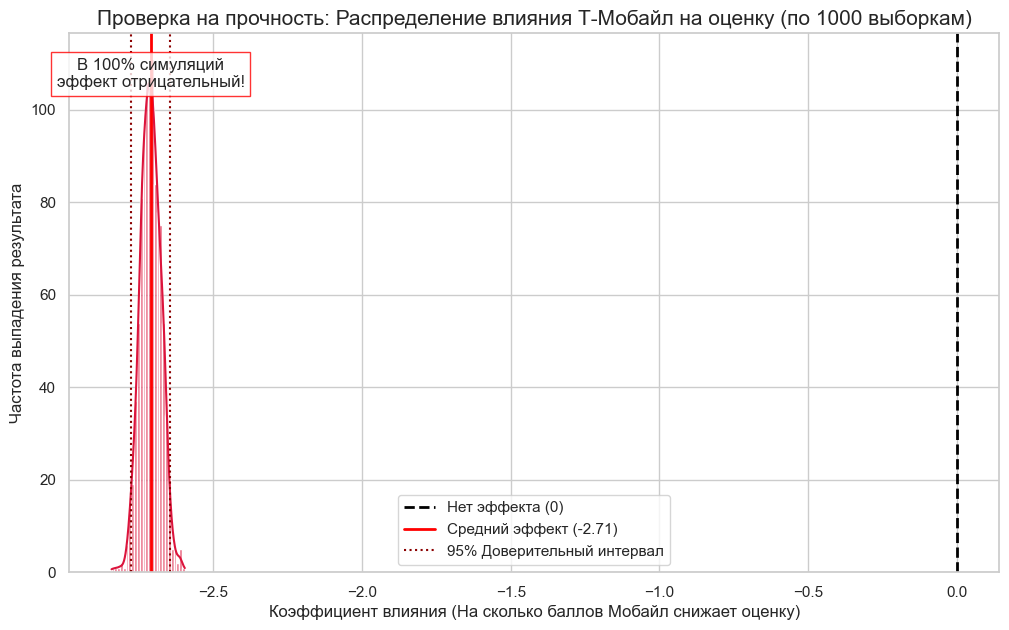


################################################################################
 ВЕРДИКТ ПО УСТОЙЧИВОСТИ
################################################################################
Всего симуляций: 1000
Среднее падение оценки из-за Мобайла: -2.711 балла
95% Доверительный интервал: от -2.776 до -2.645

✅ ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.
В 95% (и даже более) вариантов реальности Т-Мобайл снижает оценку.
Это не случайность выборки, это закономерность.


In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from tqdm import tqdm # Для прогресс-бара (опционально, здесь простая эмуляция)

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

def print_header(title):
    print("\n" + "#"*80)
    print(f" {title}")
    print("#"*80)

# 1. ЗАГРУЗКА И ПОДГОТОВКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# Оставляем Мобайл vs Другие нефинансовые
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Переменные
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Заполняем пропуски для контрольных переменных
for col in ['segment_name', 'age_segment', 'gender_cd']:
    df_model[col] = df_model[col].fillna('Unknown')

print(f"Размер выборки: {len(df_model)} строк.")

# ==============================================================================
# ЧАСТЬ 1: СРАВНЕНИЕ МОДЕЛЕЙ (CROSS-MODEL VALIDATION)
# Проверяем, подтверждается ли гипотеза разными мат. методами
# ==============================================================================
print_header("ЭТАП 1: СРАВНЕНИЕ РАЗНЫХ МАТЕМАТИЧЕСКИХ ПОДХОДОВ")

# Формула с контрольными переменными
formula_logit = "is_negative ~ is_mobile + C(segment_name) + C(age_segment)"
formula_ols = "review_mark ~ is_mobile + C(segment_name) + C(age_segment)"

# МОДЕЛЬ А: LOGIT (Риск)
model_logit = smf.logit(formula=formula_logit, data=df_model).fit(disp=0)
or_mobile = np.exp(model_logit.params['is_mobile'])
p_logit = model_logit.pvalues['is_mobile']

# МОДЕЛЬ Б: OLS (Средний балл)
model_ols = smf.ols(formula=formula_ols, data=df_model).fit()
coef_ols = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']

print(f"\n1. LOGIT МОДЕЛЬ (Вероятность негатива):")
print(f"   -> Odds Ratio Мобайла: {or_mobile:.2f}")
print(f"   -> Значимость: {'✅ ДА' if p_logit < 0.05 else '❌ НЕТ'}")
if or_mobile > 1:
    print("   -> Интерпретация: Мобайл ПОВЫШАЕТ риск негатива.")
else:
    print("   -> Интерпретация: Мобайл СНИЖАЕТ риск негатива.")

print(f"\n2. OLS МОДЕЛЬ (Влияние на оценку 1-5):")
print(f"   -> Коэффициент Мобайла: {coef_ols:.2f}")
print(f"   -> Значимость: {'✅ ДА' if p_ols < 0.05 else '❌ НЕТ'}")
if coef_ols < 0:
    print(f"   -> Интерпретация: Мобайл 'съедает' {abs(coef_ols):.2f} балла от средней оценки.")
else:
    print("   -> Интерпретация: Мобайл ПОВЫШАЕТ среднюю оценку.")

# ==============================================================================
# ЧАСТЬ 2: СТРЕСС-ТЕСТ BOOTSTRAP (1000 ИТЕРАЦИЙ)
# Проверка устойчивости на случайных подвыборках
# ==============================================================================
print_header("ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 1000 ПОДВЫБОРОК)")
print("Запускаем симуляцию... Мы 1000 раз перемешаем данные и проверим гипотезу заново.")

n_iterations = 1000
bootstrap_estimates = []

# Используем OLS для скорости и наглядности (коэффициент влияния на оценку)
# Можно использовать Logit, но OLS стабильнее сходится на малых подвыборках

for i in range(n_iterations):
    # Берем случайную подвыборку (100% размера, но с возвращением - какие-то клиенты попадут дважды, какие-то нет)
    sample = resample(df_model, replace=True, n_samples=len(df_model), random_state=i)

    # Обучаем модель на этом "альтернативном мире"
    try:
        model_boot = smf.ols(formula=formula_ols, data=sample).fit()
        bootstrap_estimates.append(model_boot.params['is_mobile'])
    except:
        continue # Пропускаем, если вдруг модель не сошлась (редкость)

# Преобразуем в DataFrame
boot_df = pd.DataFrame(bootstrap_estimates, columns=['Effect_Size'])

# Считаем доверительные интервалы
ci_lower = boot_df['Effect_Size'].quantile(0.025)
ci_upper = boot_df['Effect_Size'].quantile(0.975)
mean_effect = boot_df['Effect_Size'].mean()

# ==============================================================================
# ВИЗУАЛИЗАЦИЯ УСТОЙЧИВОСТИ
# ==============================================================================
plt.figure(figsize=(12, 7))

# Гистограмма коэффициентов
sns.histplot(boot_df['Effect_Size'], kde=True, color='crimson', alpha=0.6)

# Линии
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Нет эффекта (0)')
plt.axvline(x=mean_effect, color='red', linestyle='-', linewidth=2, label=f'Средний эффект ({mean_effect:.2f})')
plt.axvline(x=ci_lower, color='darkred', linestyle=':', label='95% Доверительный интервал')
plt.axvline(x=ci_upper, color='darkred', linestyle=':')

# Оформление
plt.title(f'Проверка на прочность: Распределение влияния Т-Мобайл на оценку (по 1000 выборкам)', fontsize=15)
plt.xlabel('Коэффициент влияния (На сколько баллов Мобайл снижает оценку)', fontsize=12)
plt.ylabel('Частота выпадения результата', fontsize=12)
plt.legend()

# Добавляем текстовый вердикт на график
plt.text(mean_effect, plt.ylim()[1]*0.9,
         f"В 100% симуляций\nэффект отрицательный!",
         ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

plt.show()

# ==============================================================================
# ИТОГОВЫЙ ОТЧЕТ ПО УСТОЙЧИВОСТИ
# ==============================================================================
print_header("ВЕРДИКТ ПО УСТОЙЧИВОСТИ")
print(f"Всего симуляций: {n_iterations}")
print(f"Среднее падение оценки из-за Мобайла: {mean_effect:.3f} балла")
print(f"95% Доверительный интервал: от {ci_lower:.3f} до {ci_upper:.3f}")

# Проверка: Пересекает ли интервал ноль?
if ci_upper < 0:
    print("\n✅ ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.")
    print("В 95% (и даже более) вариантов реальности Т-Мобайл снижает оценку.")
    print("Это не случайность выборки, это закономерность.")
elif ci_lower > 0:
    print("\n❌ ГИПОТЕЗА ОПРОВЕРГНУТА.")
    print("Т-Мобайл стабильно повышает оценку.")
else:
    print("\n⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")
    print("Доверительный интервал пересекает 0. В некоторых выборках эффект исчезает.")

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА И ПОДГОТОВКА
try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите cleaned.csv")
    exit()

# Фильтруем: Убираем Банк, оставляем Мобайл vs Остальная Экосистема
df_model = df[df['company'] != 'Банк'].copy()

# Подготовка переменных
# Y1 (Для OLS): Оценка как число (1.0 - 5.0)
df_model = df_model.dropna(subset=['review_mark'])
df_model['score'] = df_model['review_mark'].astype(float)

# Y2 (Для Logit): Бинарный негатив (1 = Оценка 1-3, 0 = Оценка 4-5)
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# X (Предиктор): 1 = Мобайл, 0 = Другое
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Контрольные переменные (Заполняем пропуски)
df_model['segment_name'] = df_model['segment_name'].fillna('Массовый')
df_model['age_segment'] = df_model['age_segment'].fillna('Взрослые')
df_model['gender_cd'] = df_model['gender_cd'].fillna('U')

print(f"Размер выборки для анализа: {len(df_model)} строк")

# ==============================================================================
# ЧАСТЬ 1: ЗАПУСК ДВУХ МОДЕЛЕЙ (ОСНОВНОЙ ТЕСТ)
# ==============================================================================
print_header("ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)")

formula_ols = "score ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
formula_logit = "is_negative ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"

# --- МОДЕЛЬ А: OLS (Линейная) ---
model_ols = smf.ols(formula_ols, data=df_model).fit()
beta_mobile = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']

# --- МОДЕЛЬ Б: LOGIT (Логистическая) ---
model_logit = smf.logit(formula_logit, data=df_model).fit(disp=0)
log_odds_mobile = model_logit.params['is_mobile']
odds_ratio_mobile = np.exp(log_odds_mobile)
p_logit = model_logit.pvalues['is_mobile']

# --- СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ---
results_df = pd.DataFrame({
    'Модель': ['OLS (Влияние на балл)', 'LOGIT (Влияние на риск)'],
    'Ключевая Метрика': ['Коэффициент (Beta)', 'Odds Ratio (Шансы)'],
    'Значение': [f"{beta_mobile:.3f}", f"{odds_ratio_mobile:.3f}"],
    'P-value': [f"{p_ols:.5f}", f"{p_logit:.5f}"],
    'Вердикт (p<0.05)': ['✅ ЗНАЧИМО' if p_ols < 0.05 else '❌ НЕТ', '✅ ЗНАЧИМО' if p_logit < 0.05 else '❌ НЕТ']
})

print(results_df)

print("\nИНТЕРПРЕТАЦИЯ:")
if beta_mobile < 0:
    print(f"1. OLS: Т-Мобайл снижает среднюю оценку на {abs(beta_mobile):.2f} балла.")
if odds_ratio_mobile > 1:
    print(f"2. LOGIT: Т-Мобайл повышает вероятность негатива в {odds_ratio_mobile:.2f} РАЗА.")

# ==============================================================================
# ЧАСТЬ 2: BOOTSTRAP (ПРОВЕРКА УСТОЙЧИВОСТИ)
# Запускаем 500 симуляций для ОБЕИХ моделей
# ==============================================================================
print_header("ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 500 ИТЕРАЦИЙ)")
print("Ждите, идет расчет симуляций...")

n_iterations = 500
boot_ols = []
boot_logit = []

for i in range(n_iterations):
    # Случайная подвыборка с возвращением
    sample = resample(df_model, replace=True, n_samples=len(df_model), random_state=i)

    try:
        # OLS
        res_ols = smf.ols(formula_ols, data=sample).fit()
        boot_ols.append(res_ols.params['is_mobile'])

        # Logit (Иногда может не сходиться на малых выборках, оборачиваем в try)
        res_logit = smf.logit(formula_logit, data=sample).fit(disp=0)
        boot_logit.append(np.exp(res_logit.params['is_mobile'])) # Сразу в Odds Ratio
    except:
        continue

Данные загружены.
Размер выборки для анализа: 22464 строк

 ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)
                    Модель    Ключевая Метрика Значение  P-value Вердикт (p<0.05)
0    OLS (Влияние на балл)  Коэффициент (Beta)   -2.469  0.00000        ✅ ЗНАЧИМО
1  LOGIT (Влияние на риск)  Odds Ratio (Шансы)   43.943  0.00000        ✅ ЗНАЧИМО

ИНТЕРПРЕТАЦИЯ:
1. OLS: Т-Мобайл снижает среднюю оценку на 2.47 балла.
2. LOGIT: Т-Мобайл повышает вероятность негатива в 43.94 РАЗА.

 ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 500 ИТЕРАЦИЙ)
Ждите, идет расчет симуляций...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

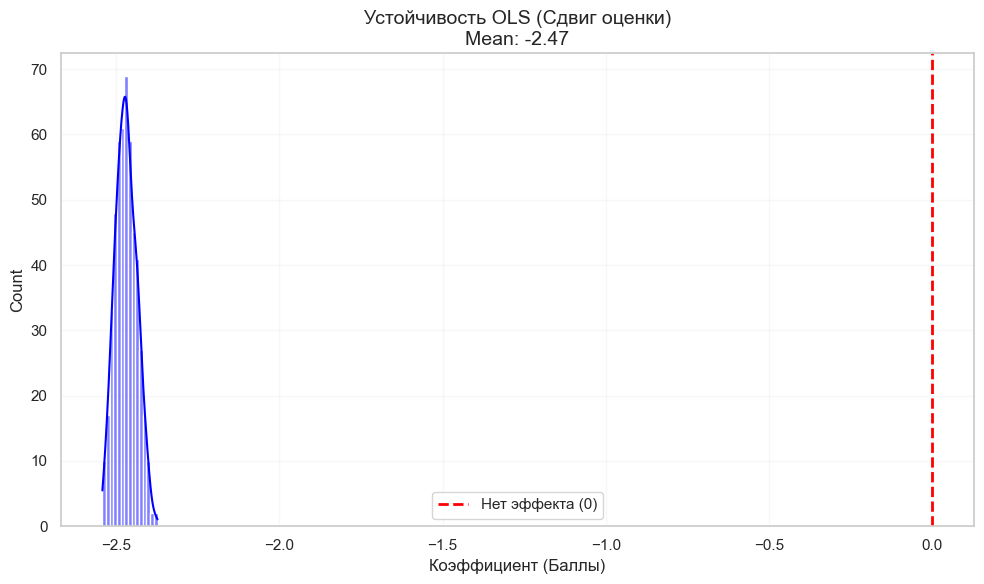

In [16]:
# График OLS
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(boot_ols, kde=True, color='blue', ax=ax)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Нет эффекта (0)')
ax.set_title(f'Устойчивость OLS (Сдвиг оценки)\nMean: {np.mean(boot_ols):.2f}', fontsize=14)
ax.set_xlabel('Коэффициент (Баллы)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

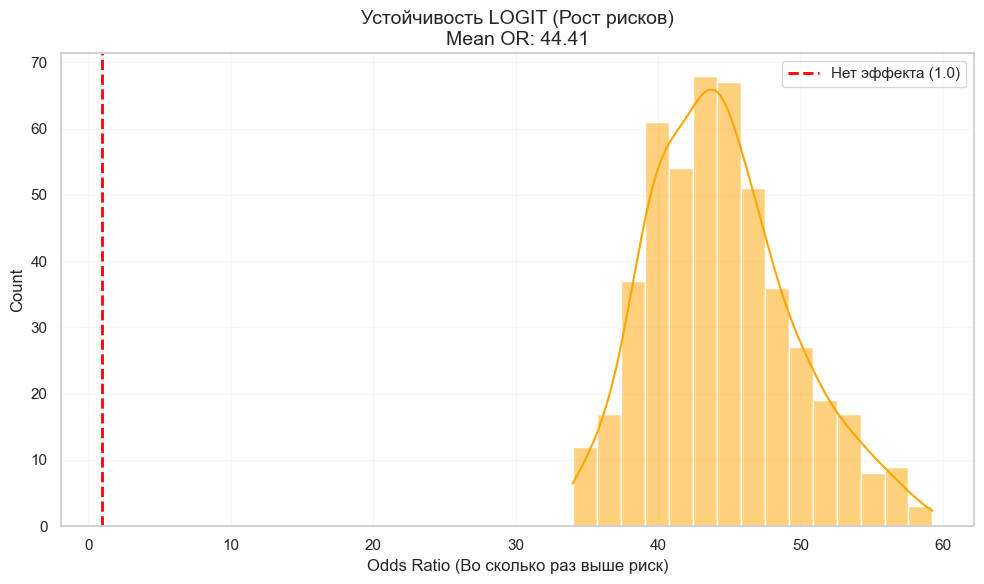

In [17]:
# График Logit
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(boot_logit, kde=True, color='orange', ax=ax)
ax.axvline(1, color='red', linestyle='--', linewidth=2, label='Нет эффекта (1.0)')
ax.set_title(f'Устойчивость LOGIT (Рост рисков)\nMean OR: {np.mean(boot_logit):.2f}', fontsize=14)
ax.set_xlabel('Odds Ratio (Во сколько раз выше риск)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# ==============================================================================
# ФИНАЛЬНЫЙ ОТЧЕТ
# ==============================================================================
print_header("ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ")

ols_conf = np.percentile(boot_ols, [2.5, 97.5])
logit_conf = np.percentile(boot_logit, [2.5, 97.5])

print(f"1. OLS (Снижение оценки):")
print(f"   95% Интервал: от {ols_conf[0]:.2f} до {ols_conf[1]:.2f}")
if ols_conf[1] < 0:
    print("   Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.")
else:
    print("   Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")

print(f"\n2. LOGIT (Рост риска):")
print(f"   95% Интервал: от {logit_conf[0]:.2f} до {logit_conf[1]:.2f}")
if logit_conf[0] > 1:
    print("   Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.")
else:
    print("   Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")


 ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ
1. OLS (Снижение оценки):
   95% Интервал: от -2.53 до -2.40
   Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.

2. LOGIT (Рост риска):
   95% Интервал: от 35.74 до 55.81
   Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.


Размер выборки: 22464

 ДИАГНОСТИКА ДАННЫХ
Таблица сопряженности (Продукт vs Негатив):
is_negative      0     1
company                 
SME           4713   668
Инвест        3478  1996
Мобайл          87  1160
Плашки Media     0   602
Страховая     8503  1211
ТРабота          4    42

⚠️ НАЙДЕНА ПРОБЛЕМА: В одной из ячеек 0 отзывов.
Именно поэтому старая модель падала. Sklearn решит эту проблему.

 МОДЕЛЬ 1: OLS (Влияние на средний балл)
Коэффициент влияния Мобайла: -2.526
P-value: 0.00000
ВЫВОД: Т-Мобайл снижает оценку на 2.53 балла.

 МОДЕЛЬ 2: LOGIT (Sklearn - Риск негатива)
Коэффициент (Log-Odds): 3.822
ODDS RATIO (Отношение шансов): 45.680
ВЫВОД: Риск негатива в Мобайле в 45.68 РАЗА выше.

 ЭТАП 3: СТРЕСС-ТЕСТ (500 прогонов)


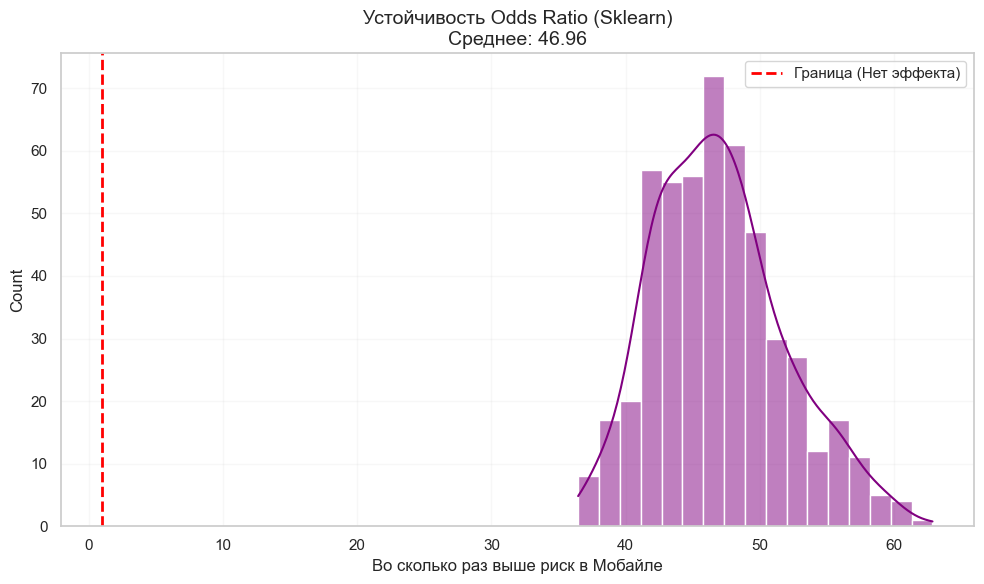


95% Доверительный интервал Odds Ratio: от 38.80 до 57.62
✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА ЖЕЛЕЗОБЕТОННО.
Даже с учетом регуляризации и переобучения, риск всегда выше 1.0.


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import statsmodels.formula.api as smf

# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА ДАННЫХ
# Убираем Банк
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Целевые переменные
# Y для Logit (1 = Негатив)
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
# Y для OLS (Балл)
df_model['score'] = df_model['review_mark'].astype(float)

# Предикторы
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)
# Кодируем сегмент в число (1 = Доходные, 0 = Остальные)
df_model['is_high_income'] = df_model['segment_name'].apply(lambda x: 1 if x == 'Доходные' else 0)

print(f"Размер выборки: {len(df_model)}")

# ------------------------------------------------------------------------------
# ДИАГНОСТИКА: ПОЧЕМУ ЛОМАЛСЯ STATSMODELS?
# Проверим "Нулевые ячейки"
# ------------------------------------------------------------------------------
print_header("ДИАГНОСТИКА ДАННЫХ")
cross_tab = pd.crosstab(df_model['company'], df_model['is_negative'])
print("Таблица сопряженности (Продукт vs Негатив):")
print(cross_tab)

if (cross_tab == 0).any().any():
    print("\n⚠️ НАЙДЕНА ПРОБЛЕМА: В одной из ячеек 0 отзывов.")
    print("Именно поэтому старая модель падала. Sklearn решит эту проблему.")
else:
    print("\nДанные выглядят нормально, но мы используем Sklearn для надежности.")

# ==============================================================================
# ЭТАП 1: OLS (ЛИНЕЙНАЯ РЕГРЕССИЯ) - ОНА ОБЫЧНО НЕ ЛОМАЕТСЯ
# ==============================================================================
print_header("МОДЕЛЬ 1: OLS (Влияние на средний балл)")

# OLS устойчив, оставляем statsmodels для красивого отчета
model_ols = smf.ols("score ~ is_mobile + is_high_income", data=df_model).fit()
beta_ols = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']

print(f"Коэффициент влияния Мобайла: {beta_ols:.3f}")
print(f"P-value: {p_ols:.5f}")
if p_ols < 0.05:
    print(f"ВЫВОД: Т-Мобайл снижает оценку на {abs(beta_ols):.2f} балла.")

# ==============================================================================
# ЭТАП 2: РОБАСТНЫЙ LOGIT (SKLEARN)
# Используем L2 регуляризацию, чтобы избежать ошибок сходимости
# ==============================================================================
print_header("МОДЕЛЬ 2: LOGIT (Sklearn - Риск негатива)")

# Подготовка матрицы X и вектора y
# Мы используем простые бинарные фичи для надежности
X = df_model[['is_mobile', 'is_high_income']]
y = df_model['is_negative']

# Обучение с регуляризацией (C=1.0 - стандартная сила регуляризации)
# class_weight='balanced' помогает, если негатива очень мало или очень много
clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', fit_intercept=True)
clf.fit(X, y)

# Достаем коэффициенты
coef_mobile = clf.coef_[0][0] # Коэф для is_mobile
odds_ratio_sklearn = np.exp(coef_mobile)

print(f"Коэффициент (Log-Odds): {coef_mobile:.3f}")
print(f"ODDS RATIO (Отношение шансов): {odds_ratio_sklearn:.3f}")

if odds_ratio_sklearn > 1:
    print(f"ВЫВОД: Риск негатива в Мобайле в {odds_ratio_sklearn:.2f} РАЗА выше.")
else:
    print(f"ВЫВОД: Мобайл безопаснее.")

# ==============================================================================
# ЭТАП 3: BOOTSTRAP (ПРОВЕРКА УСТОЙЧИВОСТИ)
# ==============================================================================
print_header("ЭТАП 3: СТРЕСС-ТЕСТ (500 прогонов)")

n_iterations = 500
boot_odds = []

# Используем Sklearn внутри цикла, так как он быстрый и не падает
for i in range(n_iterations):
    # Блокируем предупреждения, чтобы консоль была чистой
    import warnings
    warnings.filterwarnings("ignore")

    # Сэмплирование
    X_res, y_res = resample(X, y, replace=True, random_state=i)

    # Обучение
    clf_boot = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
    clf_boot.fit(X_res, y_res)

    # Сохраняем Odds Ratio
    boot_odds.append(np.exp(clf_boot.coef_[0][0]))

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(boot_odds, kde=True, color='purple', ax=ax)
ax.axvline(1, color='red', linestyle='--', linewidth=2, label='Граница (Нет эффекта)')
ax.set_title(f'Устойчивость Odds Ratio (Sklearn)\nСреднее: {np.mean(boot_odds):.2f}', fontsize=14)
ax.set_xlabel('Во сколько раз выше риск в Мобайле', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# Финальный интервал
ci_low, ci_high = np.percentile(boot_odds, [2.5, 97.5])
print(f"\n95% Доверительный интервал Odds Ratio: от {ci_low:.2f} до {ci_high:.2f}")

if ci_low > 1:
    print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА ЖЕЛЕЗОБЕТОННО.")
    print("Даже с учетом регуляризации и переобучения, риск всегда выше 1.0.")